## VADER Sentiment Analysis of WineMag.com Scrape of 130,000 Wine Reviews

The goal of this notebook is to analyze the reviews from the infamous Wine Enthusiast Kaggle Dataset, courtesy of Zack Thoutt.

Before conducting any sentiment analysis, I must normalize and tokenize the `description` column. This column contains a review for a specific wine from Zack's 2017 web scrape of winemag.com for approximately 130k reviews.

In [1]:
import pandas as pd
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from textblob import Word
import numpy as np
import re
import spacy
import random
from collections import Counter

In [2]:
df = pd.read_csv("winereviews.csv", index_col='id', na_filter=False,
                   usecols = ['id','description','points','variety'])
stop = stopwords.words('english')

Take a look at our dataframe

In [3]:
df.head()

,description,points,variety
id,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir


In the next cell we cast our column `description` into lowercase and split on whitespace

In [4]:
df['lowercase'] = df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))

This next cell defines our punctuation list and removes them from our `lowercase` pd.Series

In [5]:
punct = ['.',',','!','-','?','(',')']
df['no_punct'] = df['lowercase'].str.replace(str(punct),' ')

The following cell will remove non-alpha words and stop words (from stopwords.words('english'))

In [6]:
df['notstop'] = df['no_punct'].apply(lambda x: " ".join(x for x in x.split() 
                                                        if x.isalpha() and x not in stop))

In [7]:
df.head()

,description,points,variety,lowercase,no_punct,notstop
id,,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,"aromas include tropical fruit, broom, brimston...",aromas include tropical fruit broom brimston...,aromas include tropical fruit broom brimstone ...
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,"this is ripe and fruity, a wine that is smooth...",this is ripe and fruity a wine that is smooth...,ripe fruity wine smooth still structured firm ...
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,"tart and snappy, the flavors of lime flesh and...",tart and snappy the flavors of lime flesh and...,tart snappy flavors lime flesh rind dominate g...
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,"pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith and orange blossom ...,pineapple rind lemon pith orange blossom start...
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,"much like the regular bottling from 2012, this...",much like the regular bottling from 2012 this...,much like regular bottling comes across rather...


Use TextBlob Sentiment Analysis on Column of words that are lowercase, no punctuation, and no stop words

In [8]:
def senti(x):
    return TextBlob(x).sentiment  

Create column `senti_score` and apply Textblob sentiment analysis function

In [9]:
df['senti_score'] = df['notstop'].apply(senti)

We just applied our TextBlob sentiment analyzer to our entire pd.Series `notstop`. Let's take a look

In [10]:
df['senti_score'].head()

id
0      (0.13333333333333336, 0.7333333333333334)
1     (0.22000000000000003, 0.45999999999999996)
2    (0.024999999999999994, 0.35833333333333334)
3    (-0.16666666666666666, 0.16666666666666666)
4     (0.30666666666666664, 0.44871794871794873)
Name: senti_score, dtype: object

Hmmm... OK so we have a fairly difficult to read TextBlob object. The next few lines of code work to split each element of the object into their own respective column.

In [11]:
df['senti_score'] = df['senti_score'].astype('str')  #cast to string

Create two new columns for my scores

In [12]:
df[['polarity','subjectivity']] = df['senti_score'].str.split(',', expand = True)

Use regular expression to remove scores from TextBlob sentiment objects

In [13]:
df['polarity'] = df['polarity'].apply(lambda x: re.sub(r"[^\d.]", "", x))

In [14]:
df['subjectivity'] = df['subjectivity'].apply(lambda x: re.sub(r"[^\d.]", "", x))

Let's take a look at what we have done so far

In [15]:
df.head()

,description,points,variety,lowercase,no_punct,notstop,senti_score,polarity,subjectivity
id,,,,,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,"aromas include tropical fruit, broom, brimston...",aromas include tropical fruit broom brimston...,aromas include tropical fruit broom brimstone ...,"Sentiment(polarity=0.13333333333333336, subjec...",0.13333333333333336,0.7333333333333334
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,"this is ripe and fruity, a wine that is smooth...",this is ripe and fruity a wine that is smooth...,ripe fruity wine smooth still structured firm ...,"Sentiment(polarity=0.22000000000000003, subjec...",0.22000000000000003,0.45999999999999996
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,"tart and snappy, the flavors of lime flesh and...",tart and snappy the flavors of lime flesh and...,tart snappy flavors lime flesh rind dominate g...,"Sentiment(polarity=0.024999999999999994, subje...",0.024999999999999994,0.35833333333333334
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,"pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith and orange blossom ...,pineapple rind lemon pith orange blossom start...,"Sentiment(polarity=-0.16666666666666666, subje...",0.16666666666666666,0.16666666666666666
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,"much like the regular bottling from 2012, this...",much like the regular bottling from 2012 this...,much like regular bottling comes across rather...,"Sentiment(polarity=0.30666666666666664, subjec...",0.30666666666666664,0.44871794871794873


Awesome! Let's convert our `polarity` and `subjectivity` scores to **float**.

In [16]:
df['polarity'] = df['polarity'].astype(float)

In [17]:
df['subjectivity'] = df['subjectivity'].astype(float)

Round scores to three decimal places.

In [18]:
df['polarity'] = df['polarity'].round(3)

In [19]:
df['subjectivity'] = df['subjectivity'].round(3)

get rid of that obnoxious TextBlob Object column, `senti_score`

In [20]:
del df['senti_score']

In [21]:
df.head() # one more look before we write our dataframe to file

,description,points,variety,lowercase,no_punct,notstop,polarity,subjectivity
id,,,,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,"aromas include tropical fruit, broom, brimston...",aromas include tropical fruit broom brimston...,aromas include tropical fruit broom brimstone ...,0.133,0.733
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,"this is ripe and fruity, a wine that is smooth...",this is ripe and fruity a wine that is smooth...,ripe fruity wine smooth still structured firm ...,0.220,0.460
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,"tart and snappy, the flavors of lime flesh and...",tart and snappy the flavors of lime flesh and...,tart snappy flavors lime flesh rind dominate g...,0.025,0.358
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,"pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith and orange blossom ...,pineapple rind lemon pith orange blossom start...,0.167,0.167
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,"much like the regular bottling from 2012, this...",much like the regular bottling from 2012 this...,much like regular bottling comes across rather...,0.307,0.449


In [22]:
#df.to_csv('wine_sentiment_scores.csv')

Awesome! We have two column scores from the TextBlob Sentiment Analyzer object. Next I Visualize this information using Tableau

In [23]:
print(df['points'].describe())

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64


#### The following images were created using Tableau.
This first image is a box and whisker plot displaying the top 25 and bottom 25 wines by average wine compound sentiment score.

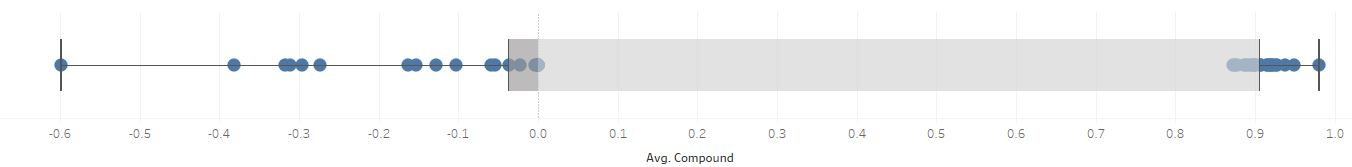

In [3]:
from IPython.display import Image
Image(filename = "avgcompoundtopandbottombox.jpg") #width=100, height=100

The next image displays the average VADER sentiment analysis compound score for the top 25 most reviewed wines in the dataset. I only wanted to consider wines with a lot of reviews!

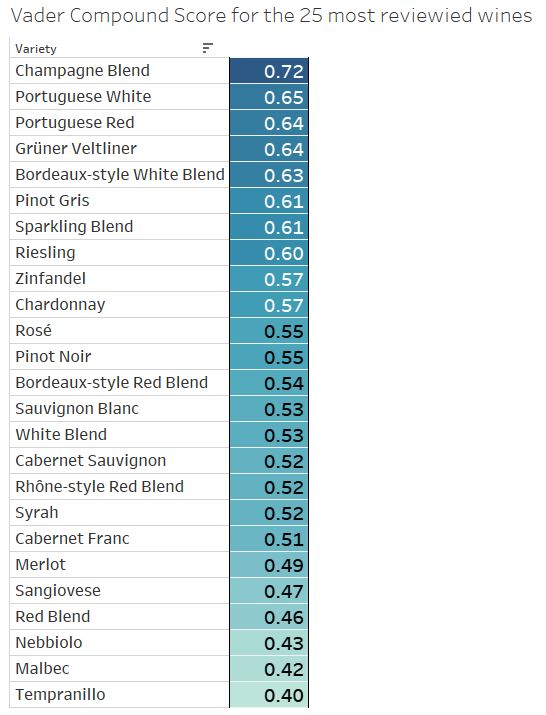

In [4]:
Image(filename = "vadertop25variety.jpg") 

Next, we see an image of the top 25 varieties as a measure of their average VADER sentiment compound score. 

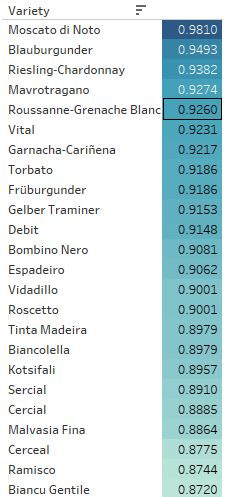

In [6]:
Image(filename = "top25compound.jpg") 

Now let's look at the bottom 25 varieties as a measure of their average VADER sentiment compound score.

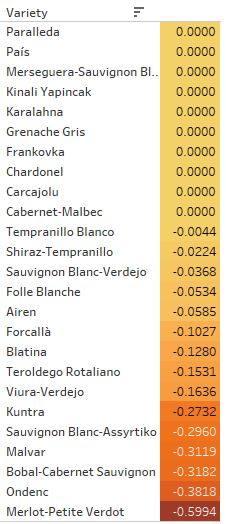

In [5]:
Image(filename = "bottom25compound.jpg") 

#### What does the point distribution look like?
After discussing my project with my girlfriend she emailed me a few articles discussing the wine scoring system. I am grateful for this information as I learned of the plight of the score of 89. Below you can see the head of the pandas dataframe grouped by variety with descriptive statistics supplied.

In [25]:
variety = df.groupby("variety")
variety.describe()

points                                                       \
              count       mean       std   min    25%   50%    75%   max   
variety                                                                    
                1.0  88.000000       NaN  88.0  88.00  88.0  88.00  88.0   
Abouriou        3.0  87.666667  3.055050  85.0  86.00  87.0  89.00  91.0   
Agiorgitiko    63.0  87.031746  1.991662  83.0  85.00  87.0  88.00  92.0   
Aglianico     359.0  89.275766  2.598721  81.0  87.00  89.0  91.00  97.0   
Aidani          1.0  82.000000       NaN  82.0  82.00  82.0  82.00  82.0   
...             ...        ...       ...   ...    ...   ...    ...   ...   
Zinfandel    2714.0  87.828666  3.111240  80.0  86.00  88.0  90.00  97.0   
Zlahtina        2.0  86.000000  2.828427  84.0  85.00  86.0  87.00  88.0   
Zweigelt      209.0  88.296651  2.269793  82.0  87.00  89.0  90.00  94.0   
Çalkarası       2.0  86.500000  0.707107  86.0  86.25  86.5  86.75  87.0   
Žilavka         1.0  88.000000       NaN  88.0  88.00  88.0  88.00  88.0   

            polarity            ...                subjectivity            \
               count      mean  ...     75%    max        count      mean   
variety                         ...                                         
                 1.0  0.412000  ...  0.4120  0.412          1.0  0.660000   
Abouriou         3.0  0.218333  ...  0.2835  0.367          3.0  0.443000   
Agiorgitiko     63.0  0.201841  ...  0.2795  0.650         63.0  0.431968   
Aglianico      359.0  0.120265  ...  0.1760  0.500        359.0  0.419142   
Aidani           1.0  0.100000  ...  0.1000  0.100          1.0  0.433000   
...              ...       ...  ...     ...    ...          ...       ...   
Zinfandel     2714.0  0.197865  ...  0.2660  9.252       2714.0  0.516507   
Zlahtina         2.0  0.330000  ...  0.3700  0.410          2.0  0.573500   
Zweigelt       209.0  0.215167  ...  0.2670  0.700        209.0  0.496230   
Çalkarası        2.0  0.625000  ...  0.6625  0.700          2.0  0.900000   
Žilavka          1.0  0.200000  ...  0.2000  0.200          1.0  0.300000   

                                                               
                  std    min      25%     50%      75%    max  
variety                                                        
                  NaN  0.660  0.66000  0.6600  0.66000  0.660  
Abouriou     0.143279  0.350  0.36050  0.3710  0.48950  0.608  
Agiorgitiko  0.169828  0.125  0.30550  0.4330  0.51800  0.875  
Aglianico    0.133588  0.000  0.32500  0.4190  0.50650  0.788  
Aidani            NaN  0.433  0.43300  0.4330  0.43300  0.433  
...               ...    ...      ...     ...      ...    ...  
Zinfandel    0.149017  0.000  0.43000  0.5250  0.61000  1.000  
Zlahtina     0.292035  0.367  0.47025  0.5735  0.67675  0.780  
Zweigelt     0.127111  0.042  0.42500  0.4950  0.57200  0.817  
Çalkarası    0.141421  0.800  0.85000  0.9000  0.95000  1.000  
Žilavka           NaN  0.300  0.30000  0.3000  0.30000  0.300  

[708 rows x 24 columns]

Here is the point distribution for all Wines, Pinot Noir, Cabernet Sauvignon, Bordeaux-Red Blend, and Chardonnay. You can see quite clearly that there is a clear bimodal distribution taking place. 

From learning more about the wine scoring system I learned how detrimental the score a wine receives to the retail sales prices. There is an enormous amount of pressure to rank a wine as a 90 that would have received an 89, just to bump them into that next tier of desirability.

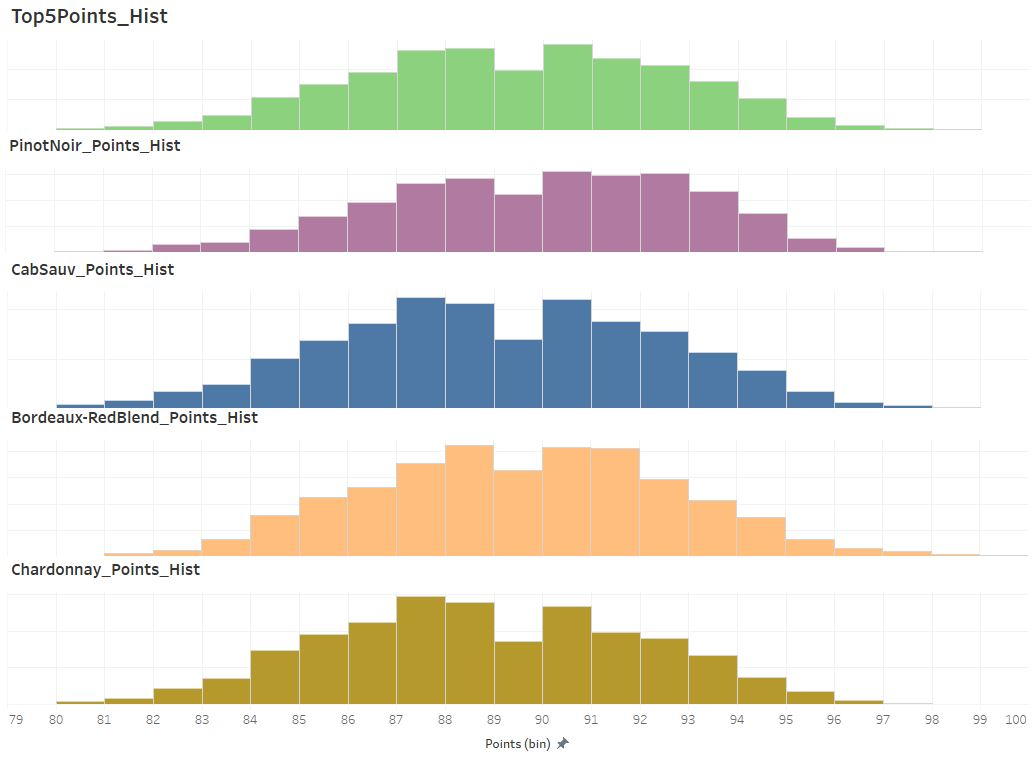

In [7]:
Image(filename = "pointdist.jpg")

In [26]:
variety.mean().sort_values(by="points",ascending=False).head()

,points,polarity,subjectivity
variety,,,
Terrantez,95.000000,0.353000,0.630000
Tinta del Pais,95.000000,0.163500,0.550000
Gelber Traminer,95.000000,0.525000,0.725000
Bual,94.142857,0.327143,0.637571
Riesling-Chardonnay,94.000000,0.375000,0.708000


## Word Clouds by Variety using Adjectives Only

Initially I created word clouds with my tokenized reviews sans stopwords, but non-interesting words kept popping up in my word clouds. Thinking about what defines a description of a wine, I decided adjectives would be more useful. In the following cells I read in a file that contains a column of adjectives extracted from each wine review. Then I use those adjectives associated with a specific wine to produce a word cloud using **WordCloud**.

Word Clouds, in order, down the page:

    1) All wines
    
    2) Pinot Noir
    
    3) Chardonnay
    
    4) Riesling
    
    5) Muscat
    
    6) Malbec

In [27]:
df2 = pd.read_csv('wine_adjectives.csv')

I use the next cell to join together my pandas.Series of adjectives in my `adj_str` column and then print out the total words in the string to make sure we are creating a word cloud with the correct variables

In [28]:
text = " ".join(review for review in df2.adj_str.astype(str))
print ("There are {} words in the bag, ready to be clouded.".format(len(text)))

There are 4614016 words in the bag, ready to be clouded.


In [29]:
import matplotlib.pyplot as plt

In [42]:
stopwords = ['wine','pinot', 'noir', 'cabernet sauvignon','flavor','finish','palate',
             'flavors','aroma','show','aromas', 'drink', 'show','give','black','red','good',
            'ripe','rich','dark','muscat','chardonnay','sweet']

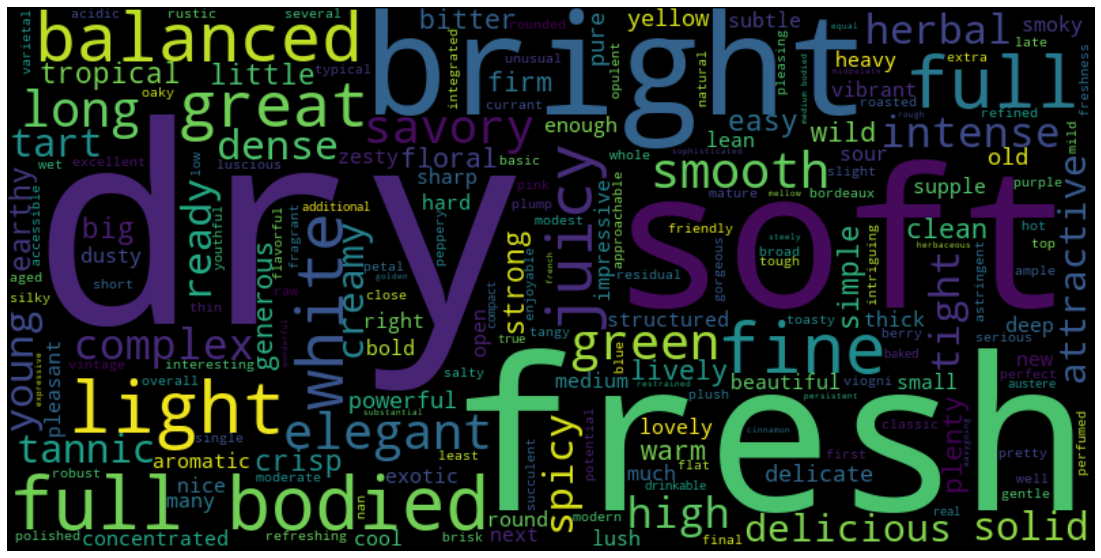

In [43]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(text)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
pinot_noir = " ".join(review for review in df2[df2["variety"]=="Pinot Noir"].adj_str.astype(str))
print ("There are {} words in the combination of all review.".format(len(pinot_noir)))

There are 491582 words in the combination of all review.


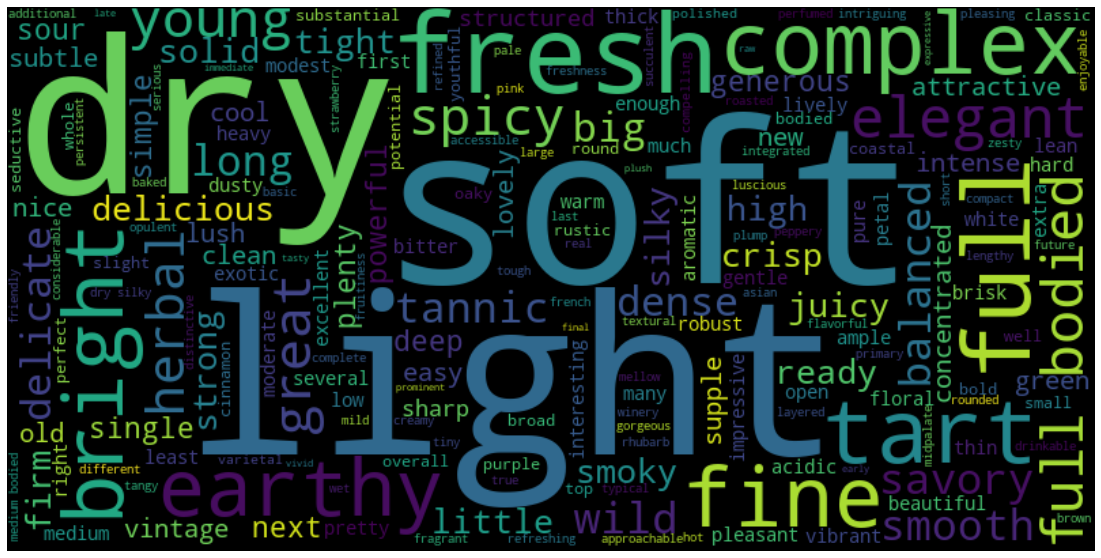

In [45]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(pinot_noir)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
chardonnay = " ".join(review for review in df2[df2["variety"]=="Chardonnay"].adj_str.astype(str))
print ("There are {} words in the combination of all review.".format(len(chardonnay)))

There are 393596 words in the combination of all review.


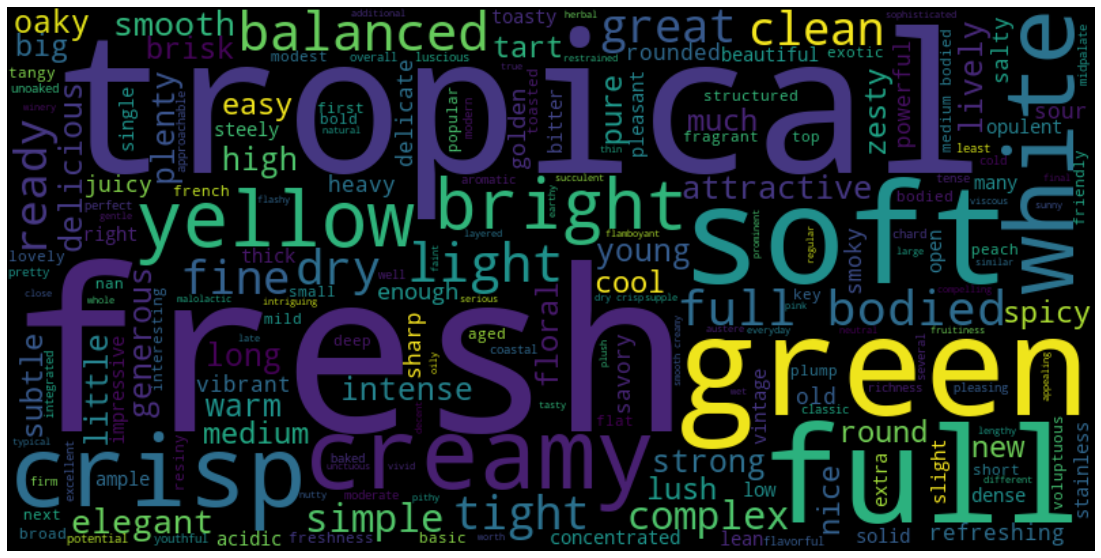

In [47]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(chardonnay)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
riesling = " ".join(review for review in df2[df2["variety"]=="Riesling"].adj_str.astype(str))
print ("There are {} words in the combination of all review.".format(len(riesling)))

There are 192842 words in the combination of all review.


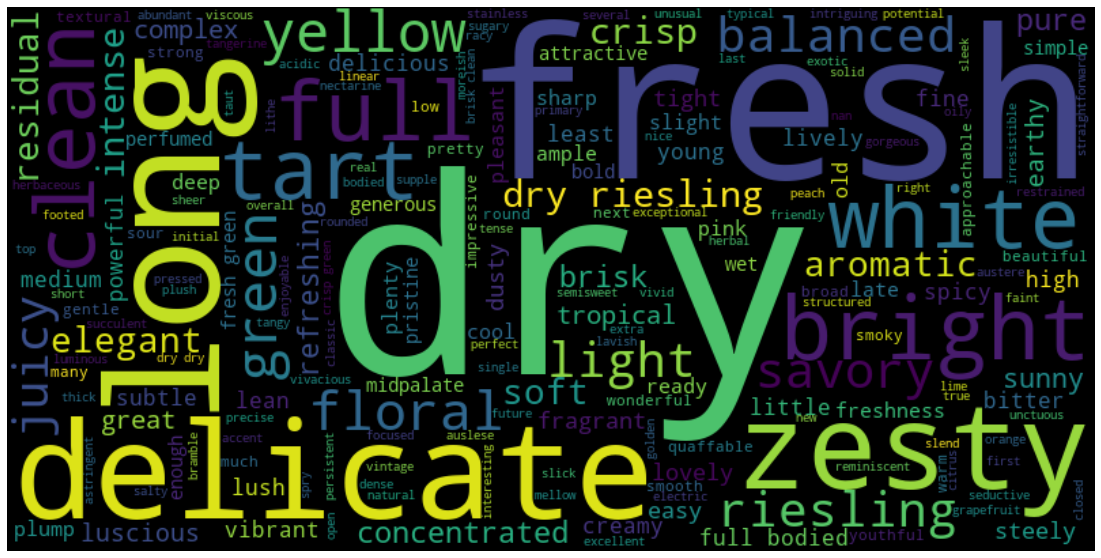

In [49]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(riesling)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [50]:
muscat = " ".join(review for review in df2[df2["variety"]=="Muscat"].adj_str.astype(str))
print ("There are {} words in the combination of all review.".format(len(muscat)))

There are 5424 words in the combination of all review.


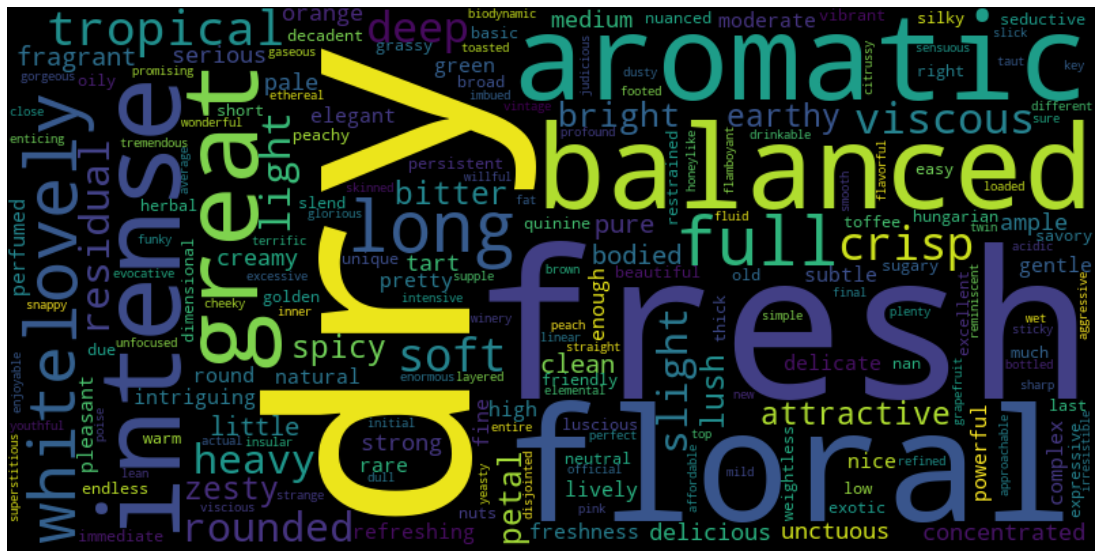

In [51]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(muscat)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
malbec = " ".join(review for review in df2[df2["variety"]=="Malbec"].adj_str.astype(str))
print ("There are {} words in the combination of all review.".format(len(malbec)))

There are 99770 words in the combination of all review.


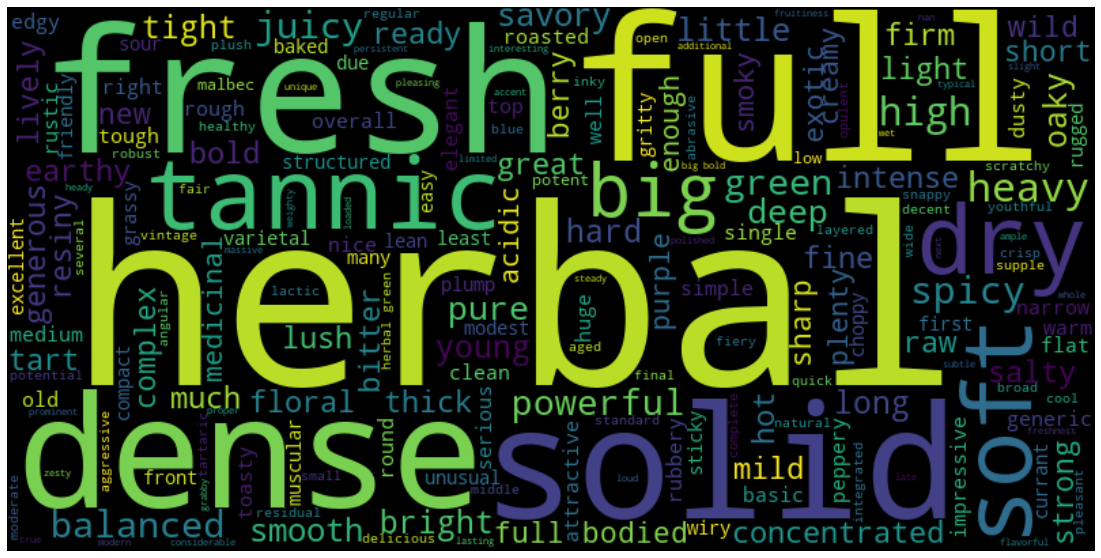

In [53]:
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(malbec)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We now have a dataset that has been amended to include a column of the lemmatized adjectives in each review. We also added a column for a sentiment score. 